In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
sns.set_style("darkgrid")

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 10

import plotly.graph_objects as go
import plotly.express as px

import pickle
import os
import gc

os.chdir("./제6회 L.POINT Big Data Competition/")

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [2]:
online_df = pd.read_csv("clear_merged_online_df.csv")
online_df = reduce_mem_usage(online_df)
online_df['time'] = pd.to_datetime(online_df.time)

Mem. usage decreased to 399.14 Mb (46.7% reduction)


In [3]:
base_df = pd.read_csv("noraml_with_group.csv")

In [5]:
categories = pd.read_csv("purchase_num_by_category.csv")

In [ ]:
# hit_pss_tm
# 구매당시 시간정보 + 구매까지의 총 hit_seq갯수
# 장바구니 이용 비율

#### 구매당시 시간정보 + 구매까지의 총 hit_seq 갯수

In [117]:
df = online_df[online_df.action_type == 6]

In [26]:
df.drop_duplicates(["clnt_id", "sess_id"], keep = "first", inplace=True)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



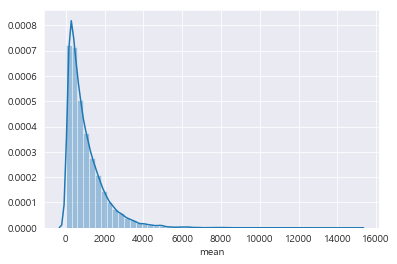

In [31]:
sns.distplot(df.groupby(["clnt_id"]).aggregate(["mean","std"])["hit_pss_tm"].fillna(0).reset_index()['mean'])

In [33]:
mean_pss_tm_to_purchase = df.groupby(["clnt_id"]).aggregate(["mean","std"])["hit_pss_tm"].fillna(0).reset_index()

####  구매당시 시간정보 + 구매까지의 총 hit_seq갯수

In [118]:
def get_time_range(hour):
    if (hour >= 1) & (hour <= 8) :
        return "dawn"
    elif (hour >= 9) & (hour <= 18):
        return "daytime"
    else:
        return "night"

In [119]:
df["time_range"] = df.hour.apply(lambda x : get_time_range(x))

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [120]:
df["is_holiday"] = np.where(df.weekday.isin([0,1,2,3,4]), 0, 1)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [121]:
with open("holiday_list.pickle", "rb") as f:
    holiday_list = pickle.load(f)

In [122]:
holiday_list

['20190717', '20190815', '20190912', '20190913', '20190914']

In [123]:
pd.DataFrame(np.where(df.sess_dt.isin(holiday_list), 1, 0))[0].value_counts()

0    124704
1      4978
Name: 0, dtype: int64

In [124]:
df.loc[df.sess_dt.isin(holiday_list), "is_holiday"] = 1

c:\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [132]:
main_buying_time = df.drop_duplicates(["clnt_id", "trans_id"], keep = "first").groupby(["clnt_id","time_range"]).size().reset_index().sort_values(by = ["clnt_id", 0], ascending = [1,0]).drop_duplicates(["clnt_id"], keep = "first").reset_index(drop = True)[["clnt_id","time_range"]]

In [136]:
main_buying_day = df.drop_duplicates(["clnt_id", "trans_id"], keep = "first").groupby(["clnt_id","is_holiday"]).size().reset_index().sort_values(by = ["clnt_id", 0], ascending = [1,0]).drop_duplicates(["clnt_id"], keep = "first").reset_index(drop = True)[["clnt_id","is_holiday"]]

In [137]:
buying_time_info = main_buying_time.merge(main_buying_day)

In [143]:
mean_hit_seq_to_buy = df.drop_duplicates(["clnt_id", "trans_id"], keep = "first").groupby("clnt_id").mean().hit_seq.reset_index()

In [145]:
buying_clnt_info = buying_time_info.merge(mean_hit_seq_to_buy)

In [147]:
buying_clnt_info.head()

,clnt_id,time_range,is_holiday,hit_seq
0,2,night,0,34.5
1,4,daytime,0,2.0
2,9,daytime,0,26.5
3,12,daytime,0,2.0
4,17,dawn,0,63.0


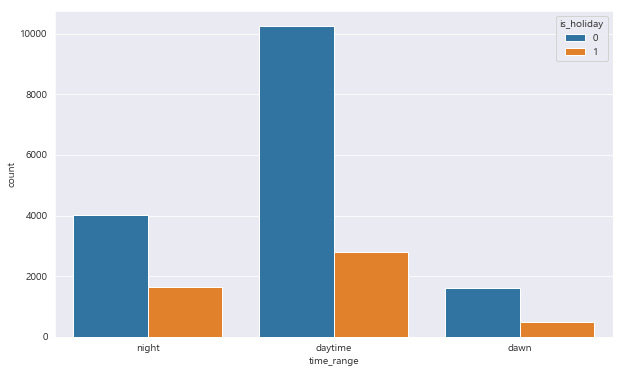

In [151]:
plt.figure(figsize = (10,6))
sns.countplot(buying_clnt_info.time_range, hue=buying_clnt_info.is_holiday)

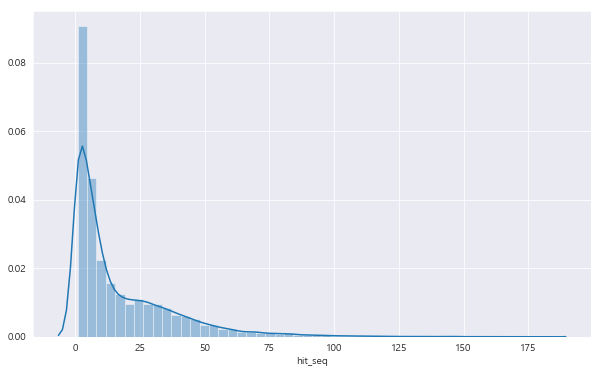

In [152]:
plt.figure(figsize = (10,6))
sns.distplot(buying_clnt_info.hit_seq)

In [61]:
df[df.hit_seq == 1].trfc_src.value_counts()

unknown     6224
DIRECT       672
WEBSITE      214
PUSH         140
PORTAL_1      92
PORTAL_2      17
PORTAL_3      11
Name: trfc_src, dtype: int64

In [62]:
df[df.hit_seq <= 3].trfc_src.value_counts()

unknown     9340
DIRECT      1086
WEBSITE      273
PUSH         206
PORTAL_1     128
PORTAL_2      28
PORTAL_3      14
Name: trfc_src, dtype: int64

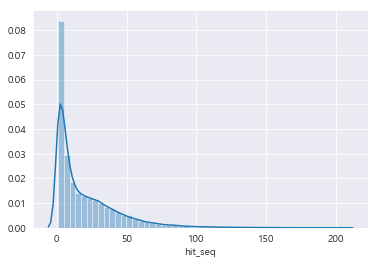

In [63]:
sns.distplot(df.hit_seq)

In [64]:
df[df.hit_seq <=4]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3,time_range,is_holiday
276,4,1,2,6,A01,20190826,10:38,402,85046.0,NaN,...,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN,daytime,0
628,12,1,2,6,A01,20190718,10:10,133,54099.0,NaN,...,-1,-1.0,-1.0,F,40,NaN,NaN,NaN,daytime,0
741,19,1,1,6,A01,20190810,16:33,1377,72882.0,NaN,...,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN,daytime,1
742,20,1,1,6,A01,20190731,20:40,624,64923.0,NaN,...,-1,-1.0,-1.0,F,30,NaN,NaN,NaN,night,0
759,22,4,4,6,A01,20190917,09:29,2646,102568.0,NaN,...,-1,-1.0,-1.0,M,30,NaN,NaN,NaN,daytime,0
784,23,6,1,6,A01,20190720,00:37,167,55760.0,NaN,...,838,27000.0,1.0,F,40,Kids' Clothing,Preschoolers' Full Bodywear,Infant / Toddlers' Dresses,night,1
791,23,8,1,6,A01,20190724,18:56,138,59081.0,NaN,...,-1,-1.0,-1.0,F,40,NaN,NaN,NaN,daytime,0
792,23,9,1,6,A01,20190730,13:53,560,64012.0,NaN,...,-1,-1.0,-1.0,F,40,NaN,NaN,NaN,daytime,0
793,23,10,1,6,A01,20190807,11:52,258,70570.0,NaN,...,-1,-1.0,-1.0,F,40,NaN,NaN,NaN,daytime,0
824,23,21,1,6,A01,20190925,00:25,1400,108951.0,NaN,...,-1,-1.0,-1.0,F,40,NaN,NaN,NaN,night,0


In [67]:
online_df[(online_df.clnt_id ==22 ) & (online_df.sess_id ==4)]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,min,trans_seq,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
756,22,4,1,0,A01,20190917,08:45,8,NaN,에어맥스,...,45,-1.0,-1,-1.0,-1.0,M,30,NaN,NaN,NaN
757,22,4,2,0,A01,20190917,08:52,407,NaN,맥스 95,...,52,-1.0,-1,-1.0,-1.0,M,30,NaN,NaN,NaN
758,22,4,3,0,A01,20190917,09:04,1143,NaN,맥스 95,...,4,-1.0,-1,-1.0,-1.0,M,30,NaN,NaN,NaN
759,22,4,4,6,A01,20190917,09:29,2646,102568.0,NaN,...,29,-1.0,-1,-1.0,-1.0,M,30,NaN,NaN,NaN


In [72]:
tmp_df = online_df.merge(pd.read_csv("buying_sess_df.csv"), how ="left")

In [75]:
tmp_df = tmp_df[tmp_df.buying_sess == 1]

In [161]:
 #buying_clnt_info.to_csv("buying_clnt_info.csv", index = False)

In [81]:
hit_num = df.hit_seq.value_counts().reset_index().sort_values(by = "index")

In [82]:
hit_num["cum_sum"] = hit_num.hit_seq.cumsum()

In [91]:
hit_num.cum_sum.values[-1]

47407

In [55]:
df.groupby("clnt_id").aggregate(["mean","count"])["hit_seq"].reset_index()

,clnt_id,mean,count
0,2,34.500000,4
1,4,2.000000,1
2,9,26.500000,2
3,12,2.000000,1
4,17,63.000000,1
5,19,1.000000,1
6,20,1.000000,1
7,22,4.000000,1
8,23,2.285714,7
9,24,45.000000,2


In [49]:
time_info = df[["clnt_id","time_range","is_holiday"]].reset_index(drop = True)

4) 장바구니에서 일부만 산 횟수(* 관측 이전에 장바구니 추가한 경우 고려해야함)  
   : 한 구매세션 내에서 item_quantities < quantity_fluctuation인 경우(장바구니에 안 산물건 남아있을 것)  
5) mean_buy_ct는 평균적으로 구매한 수량에 대한 것인데 [평균적으로 구매한 상품종류] 변수가 더 유의미할듯  
6) 한 세션 내에서 평균 구매 횟수(보통은 1이겠지만)  

In [2]:
jangbaguni = pd.read_csv("shopping_carts.csv")

In [22]:
jangbaguni

,clnt_id,sess_id,item_quantities,transaction_count,add_counts,delete_counts,quantity_fluctuation,pattern
0,2,1,1,1,2.0,0.0,2.0,3.0
1,2,8,5,1,7.0,2.0,5.0,5.0
2,2,10,1,1,1.0,0.0,1.0,5.0
3,2,19,3,1,4.0,0.0,4.0,4.0
4,4,1,1,1,0.0,0.0,0.0,1.0
5,9,6,9,1,3.0,0.0,3.0,2.0
6,9,26,8,1,5.0,0.0,5.0,2.0
7,12,1,1,1,0.0,0.0,0.0,1.0
8,17,3,1,1,10.0,6.0,4.0,3.0
9,19,1,1,1,0.0,0.0,0.0,1.0


In [3]:
# 장바구니를 이용하지 않고 구매를 한 경우 or 이미 장바구니에 들어있던것을 구매한 경우
# 이전 session에서 장바구니에 상품을 추가하고 해당 session에서 구매를 진행한 경우
# 장바구니에 여러개 담고 하나만 사는 경우
# 장바구니에 여러개 담고 그중에 선택해서 구매
# 장바구니에 담음 모든 물품을 구매하는경우 ( item_quantity == quantity_fluctuaion )
# 한 세션 내에서 2번 이상 결제를 진행한 경우

In [4]:
# 장바구니를 이용하지 않고 구매를 한 경우 
jangbaguni[(jangbaguni.item_quantities > jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities == 1)].head()

,clnt_id,sess_id,item_quantities,transaction_count,add_counts,delete_counts,quantity_fluctuation
4,4,1,1,1,0.0,0.0,0.0
7,12,1,1,1,0.0,0.0,0.0
9,19,1,1,1,0.0,0.0,0.0
10,20,1,1,1,0.0,0.0,0.0
11,22,4,1,1,0.0,0.0,0.0


In [5]:
jangbaguni.loc[(jangbaguni.item_quantities > jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities == 1), "pattern"] = 1

In [6]:
# 이전 session에서 장바구니에 상품을 추가하고 해당 session에서 구매를 진행한 경우
jangbaguni[(jangbaguni.item_quantities > jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities != 1)].head()

,clnt_id,sess_id,item_quantities,transaction_count,add_counts,delete_counts,quantity_fluctuation,pattern
5,9,6,9,1,3.0,0.0,3.0,NaN
6,9,26,8,1,5.0,0.0,5.0,NaN
20,24,15,8,1,9.0,2.0,7.0,NaN
25,40,28,3,2,0.0,0.0,0.0,NaN
27,40,37,2,1,0.0,0.0,0.0,NaN


In [7]:
jangbaguni.loc[(jangbaguni.item_quantities > jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities != 1), "pattern"] = 2

In [8]:
# 장바구니에 여러개 담고 하나만 사는 경우
jangbaguni[(jangbaguni.item_quantities < jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities == 1)].head()

,clnt_id,sess_id,item_quantities,transaction_count,add_counts,delete_counts,quantity_fluctuation,pattern
0,2,1,1,1,2.0,0.0,2.0,NaN
8,17,3,1,1,10.0,6.0,4.0,NaN
37,49,5,1,1,9.0,1.0,8.0,NaN
60,52,4,1,1,4.0,1.0,3.0,NaN
61,53,2,1,1,4.0,0.0,4.0,NaN


In [9]:
jangbaguni.loc[(jangbaguni.item_quantities < jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities == 1), "pattern"] = 3

In [10]:
# 장바구니에 여러개 담고 그중에 선택해서 구매
jangbaguni[(jangbaguni.item_quantities < jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities != 1)].head()

,clnt_id,sess_id,item_quantities,transaction_count,add_counts,delete_counts,quantity_fluctuation,pattern
3,2,19,3,1,4.0,0.0,4.0,NaN
19,24,5,9,1,18.0,2.0,16.0,NaN
38,49,6,9,1,17.0,5.0,12.0,NaN
39,49,7,9,1,15.0,3.0,12.0,NaN
40,49,9,7,2,31.0,3.0,28.0,NaN


In [11]:
jangbaguni.loc[(jangbaguni.item_quantities < jangbaguni.quantity_fluctuation) & (jangbaguni.item_quantities != 1), "pattern"] = 4

In [12]:
# 한 세션 내에서 2번 이상 결제를 진행한 경우
jangbaguni[jangbaguni.transaction_count > 1].head()

,clnt_id,sess_id,item_quantities,transaction_count,add_counts,delete_counts,quantity_fluctuation,pattern
25,40,28,3,2,0.0,0.0,0.0,2.0
32,42,4,4,4,0.0,0.0,0.0,2.0
40,49,9,7,2,31.0,3.0,28.0,4.0
73,74,2,3,3,1.0,0.0,1.0,2.0
77,80,1,3,2,0.0,0.0,0.0,2.0


In [13]:
jangbaguni.loc[jangbaguni.item_quantities == jangbaguni.quantity_fluctuation, "pattern"] = 5

In [14]:
jangbaguni.loc[jangbaguni.transaction_count > 1, "pattern"] = 6

In [16]:
jangbaguni.pattern.value_counts()

1.0    19875
3.0     9564
6.0     6527
2.0     5338
5.0     3910
4.0     2193
Name: pattern, dtype: int64

In [17]:
jangbaguni.to_csv("jangbaguni_pattern.csv", index = False)

In [24]:
# clnt_id별 session 당 평균 구매횟수
mean_transaction_count = jangbaguni.groupby(["clnt_id"]).mean()[["item_quantities","transaction_count"]]

In [28]:
mean_transaction_count.to_csv("mean_transaction_count.csv", index = False)

In [27]:
mean_transaction_count.reset_index()

,clnt_id,item_quantities,transaction_count
0,2,2.500000,1.000000
1,4,1.000000,1.000000
2,9,8.500000,1.000000
3,12,1.000000,1.000000
4,17,1.000000,1.000000
5,19,1.000000,1.000000
6,20,1.000000,1.000000
7,22,1.000000,1.000000
8,23,1.000000,1.000000
9,24,8.500000,1.000000


In [ ]:
# hit_pss_tm


In [36]:
pd.options.display.max_columns = 50

In [39]:
online_df[online_df.action_type == 6]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,time,year,month,day,weekday,hour,min,trans_seq,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
46,2,1,37,6,A03,20190728,23:47,791,62037.0,NaN,55.0,872.0,DIRECT,unknown,2019-07-28 23:47:00,2019,7,28,6,23,47,-1.0,-1,-1.0,-1.0,F,30,NaN,NaN,NaN
145,2,8,68,6,A03,20190731,21:25,3251,64691.0,NaN,85.0,3256.0,DIRECT,unknown,2019-07-31 21:25:00,2019,7,31,2,21,25,5.0,92,1800.0,1.0,F,30,Beverages,Coffee Drinks,Coffee Drinks
146,2,8,68,6,A03,20190731,21:25,3251,64691.0,NaN,85.0,3256.0,DIRECT,unknown,2019-07-31 21:25:00,2019,7,31,2,21,25,2.0,151,3990.0,1.0,F,30,Canned / Jarred Foods,Canned Agricultural Foods,Canned Vegetable Foods
147,2,8,68,6,A03,20190731,21:25,3251,64691.0,NaN,85.0,3256.0,DIRECT,unknown,2019-07-31 21:25:00,2019,7,31,2,21,25,3.0,351,4690.0,1.0,F,30,Dairy Products,Processed Dairy Products,Cream and Condensed milk
148,2,8,68,6,A03,20190731,21:25,3251,64691.0,NaN,85.0,3256.0,DIRECT,unknown,2019-07-31 21:25:00,2019,7,31,2,21,25,4.0,189,4290.0,1.0,F,30,Chilled Foods,Fish Cakes and Crab Sticks,Fried Tofu
149,2,8,68,6,A03,20190731,21:25,3251,64691.0,NaN,85.0,3256.0,DIRECT,unknown,2019-07-31 21:25:00,2019,7,31,2,21,25,1.0,186,3790.0,1.0,F,30,Chilled Foods,Fish Cakes and Crab Sticks,Crab Sticks
171,2,10,16,6,A03,20190801,22:00,306,65505.0,NaN,23.0,353.0,DIRECT,unknown,2019-08-01 22:00:00,2019,8,1,3,22,0,1.0,92,9000.0,5.0,F,30,Beverages,Coffee Drinks,Coffee Drinks
251,2,19,17,6,A03,20190830,22:00,2227,88495.0,NaN,29.0,2252.0,DIRECT,unknown,2019-08-30 22:00:00,2019,8,30,4,22,0,2.0,1395,2850.0,1.0,F,30,Substitute Foods,Instant Noodles,Ramens
252,2,19,17,6,A03,20190830,22:00,2227,88495.0,NaN,29.0,2252.0,DIRECT,unknown,2019-08-30 22:00:00,2019,8,30,4,22,0,3.0,1395,5700.0,2.0,F,30,Substitute Foods,Instant Noodles,Ramens
253,2,19,17,6,A03,20190830,22:00,2227,88495.0,NaN,29.0,2252.0,DIRECT,unknown,2019-08-30 22:00:00,2019,8,30,4,22,0,1.0,1395,3590.0,1.0,F,30,Substitute Foods,Instant Noodles,Ramens


In [58]:
# mean_time_to_buy = online_df[online_df.action_type == 6].drop_duplicates(["clnt_id","trans_id"]).groupby(["clnt_id"]).mean()["hit_pss_tm"].reset_index()

In [44]:
tmp_df = online_df[online_df.action_type == 6].drop_duplicates(["clnt_id","trans_id"])

In [51]:
tmp_df["time_rate"] = np.round(tmp_df.hit_pss_tm / tmp_df.tot_sess_hr_v,2) * 100

In [56]:
mean_time_to_buy = tmp_df.groupby("clnt_id").mean()[["hit_pss_tm", "time_rate"]].reset_index()

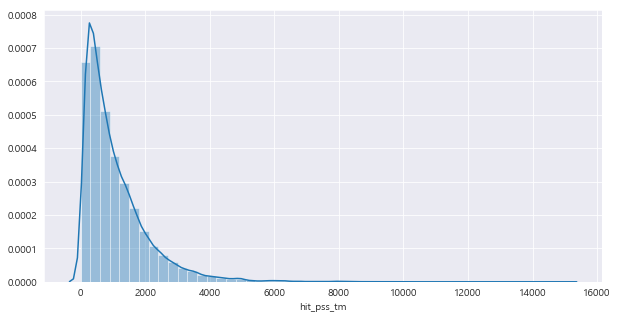

In [59]:
plt.figure(figsize = (10,5))
sns.distplot(mean_time_to_buy.hit_pss_tm)

구매까지 걸리는 시간의 평균은 약 1064초  
[ 50% : 768초, 75% : 1449초, 90% : 2307초, 99% : 4757초 ]

In [66]:
mean_time_to_buy = mean_time_to_buy[["clnt_id", "hit_pss_tm"]]

In [68]:
mean_time_to_buy.to_csv("mean_time_to_buy.csv", index = False)

### 소비패턴 정리

In [3]:
jangbaguni_2 = pd.read_csv("jangbaguni_using_dataset.csv")

In [4]:
buying_clnt_info = pd.read_csv("buying_clnt_info.csv")

In [5]:
mean_time_to_buy = pd.read_csv("mean_time_to_buy.csv")

In [6]:
clnt_consumption = buying_clnt_info.merge(jangbaguni_2).merge(mean_time_to_buy)

In [168]:
clnt_consumption.head()

,clnt_id,time_range,is_holiday,hit_seq,item_quantities,transaction_count,add_or_delete,use_rate,action_0,action_1,action_2,action_3,action_4,action_5,action_6,action_7,part_purchase,hit_pss_tm
0,2,night,0,34.5,2.5,1.0,4.0,1.0,0,0,0,0,0,4,6,0,2,1643.75
1,4,daytime,0,2.0,1.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,402.00
2,9,daytime,0,26.5,8.5,1.0,4.0,1.0,0,0,0,0,0,2,15,0,0,1498.50
3,12,daytime,0,2.0,1.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,133.00
4,17,dawn,0,63.0,1.0,1.0,16.0,1.0,0,0,0,0,0,1,0,0,1,3976.00


In [13]:
tot_sess_cnt = online_df[online_df.action_type == 6].drop_duplicates(["clnt_id","trans_id"], keep = "first").groupby("clnt_id").size().reset_index(name = "tot_sess_counts")

In [16]:
clnt_consumption = clnt_consumption.merge(tot_sess_cnt)

In [17]:
clnt_consumption["part_purchase_rate"] = clnt_consumption.part_purchase / clnt_consumption.tot_sess_counts

In [21]:
clnt_consumption.to_csv("consumption_info.csv", index = False)

#### 구매 시점

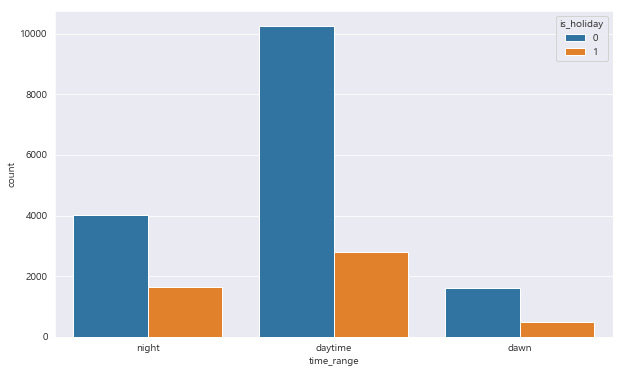

In [169]:
plt.figure(figsize = (10,6))
sns.countplot(clnt_consumption.time_range, hue = clnt_consumption.is_holiday)

#### clnt별 구매까지 걸리는 평균hit_seq의 분포 및 평균hit_pss_tm의 분포

Text(0.5, 1.0, 'DIstribution of Hit Sequence to Purchase')

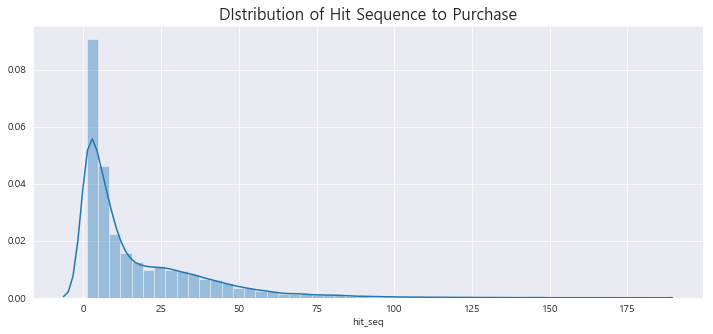

In [173]:
plt.figure(figsize = (12,5))
sns.distplot(clnt_consumption.hit_seq)
plt.title("DIstribution of Hit Sequence to Purchase", fontsize = 16)

Text(0.5, 1.0, 'DIstribution of Hit Pass Time to Purchase')

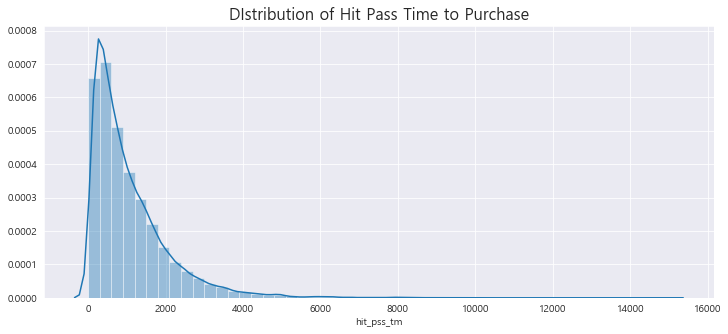

In [174]:
plt.figure(figsize = (12,5))
sns.distplot(clnt_consumption.hit_pss_tm)
plt.title("DIstribution of Hit Pass Time to Purchase", fontsize = 16)

#### 장바구니 이용률 

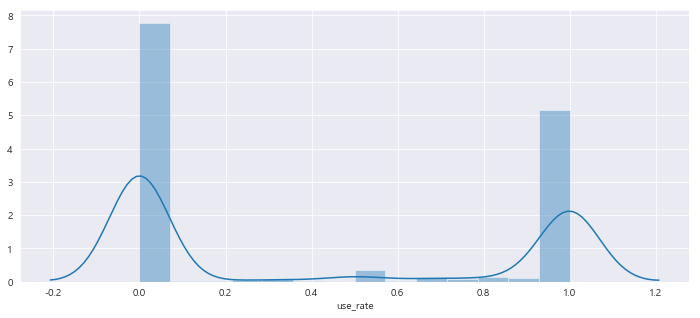

In [171]:
plt.figure(figsize = (12,5))
sns.distplot(clnt_consumption.use_rate)

#### 부분구매 비율 분포

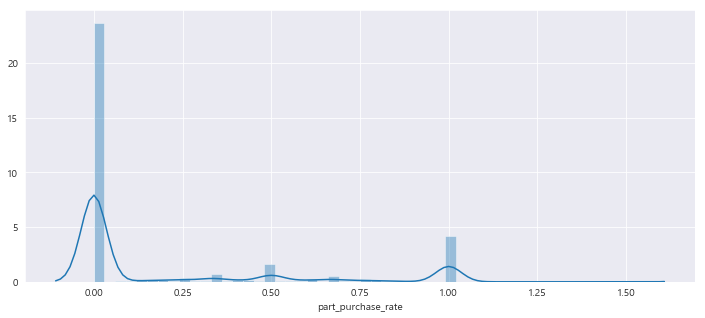

In [19]:
plt.figure(figsize = (12,5))
sns.distplot(clnt_consumption.part_purchase_rate)